# FineTuning BERT for Multi-Class Classification with custom datasets

we will fine-tune the Turkish BERT, namely BERTurk, to perform seven-class classification downstream tasks with a custom dataset. This dataset has been compiled from Turkish newspapers and consists of seven categories. We will start by getting the dataset.

In [1]:
import torch, os
# from google.colab import drive
# drive.mount('/content/drive')
# if os.getcwd() != "/content/drive/My Drive/akademi/Packt NLP with Transformers/CH05":
#   os.chdir("drive/MyDrive/akademi/Packt NLP with Transformers/CH05")

In [ ]:
# !pip install transformers datasets

## Loading Pre-Trained Model

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Obtaining and Preparing downstream task data

In [3]:
if "TTC4900.csv" not in os.listdir():
 !wget  https://raw.githubusercontent.com/savasy/TurkishTextClassification/master/TTC4900.csv
else:
   print("Already there !")

Already there !


In [4]:
import pandas as pd
data= pd.read_csv("TTC4900.csv")
data=data.sample(frac=1.0, random_state=42)
data.head(5)

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


Let's organize the IDs and labels with id2label and label2id to make the model figure out which ID refers to which label. We will also pass the number of labels, NUM_LABELS, to the model to specify the size of a thin classification head layer on top of the BERT model:

In [5]:
labels=["teknoloji","ekonomi","saglik","siyaset","kultur","spor","dunya"]
NUM_LABELS= len(labels)
id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

In [6]:
label2id

{'teknoloji': 0,
 'ekonomi': 1,
 'saglik': 2,
 'siyaset': 3,
 'kultur': 4,
 'spor': 5,
 'dunya': 6}

In [7]:
data["labels"]=data.category.map(lambda x: label2id[x.strip()])
data.head()

,category,text,labels
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,5
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,6
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,5


Let's count and plot the number of classes using a pandas object:

<AxesSubplot:ylabel='category'>

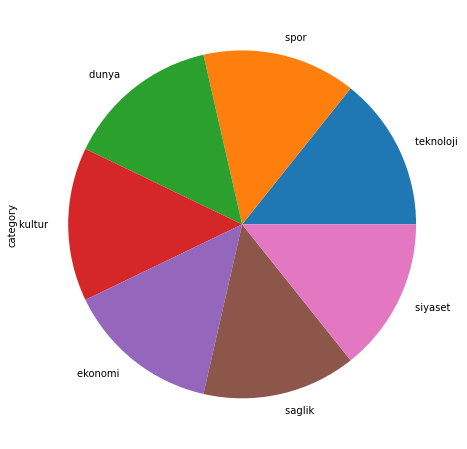

In [8]:
data.category.value_counts().plot(kind='pie', figsize=(8,8))

In [9]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)

In [10]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Splitting data


In [12]:
SIZE= data.shape[0]

train_texts= list(data.text[:SIZE//2])
val_texts=   list(data.text[SIZE//2:(3*SIZE)//4 ])
test_texts=  list(data.text[(3*SIZE)//4:])

train_labels= list(data.labels[:SIZE//2])
val_labels=   list(data.labels[SIZE//2:(3*SIZE)//4])
test_labels=  list(data.labels[(3*SIZE)//4:])

In [13]:
len(train_texts), len(val_texts), len(test_texts)

(2450, 1225, 1225)

In [14]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [15]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [16]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

## Training with Trainer Class

In [17]:
from transformers import TrainingArguments, Trainer

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    return { 
        'Accuracy': acc, 
        'F1': f1, 
        'Precision': precision, 
        'Recall': recall 
    } 

In [19]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [20]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using cuda_amp half precision backend


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

/home/guy/anaconda3/envs/mastrans/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2450
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 462
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.872200,1.615832,0.555918,0.560571,0.615015,0.554631
100,0.827800,0.357165,0.894694,0.894285,0.902517,0.896272
150,0.360300,0.302169,0.903673,0.903261,0.905230,0.903579
200,0.215200,0.331377,0.916735,0.916649,0.918252,0.916701
250,0.272600,0.339319,0.917551,0.916034,0.917798,0.917727
300,0.235200,0.283058,0.927347,0.926903,0.928268,0.926592
350,0.167000,0.305638,0.922449,0.921976,0.923133,0.921817
400,0.064800,0.316569,0.928163,0.927400,0.927462,0.928176
450,0.090500,0.310763,0.924082,0.923547,0.923853,0.923691


***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=462, training_loss=0.445126879524875, metrics={'train_runtime': 1013.8674, 'train_samples_per_second': 7.249, 'train_steps_per_second': 0.456, 'total_flos': 1933953073920000.0, 'train_loss': 0.445126879524875, 'epoch': 3.0})

In [23]:
q=[trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

***** Running Evaluation *****
  Num examples = 2450
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.039678,0.991020,0.991017,0.990929,0.991156
val,0.309829,0.924898,0.924387,0.924517,0.924566
test,0.295285,0.928163,0.927056,0.927377,0.927180


we can track the experiment via tensorboard. to do so, we need to run the following:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir multi-class-logs/

and if we're running the notebook from a remote client we need to do the following:
- connect to the server : `ssh guy@10.0.0.50 -N -f -L localhost:16006:localhost:6006`
- open a browser on the client and visit `localhost:16006`

Let's design a function that will run the model for inference. If you want to see a real label instead of an ID, you can use the config object of our model, as shown in the following predict function:

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [24]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

In [25]:
# Example #1
text = "Fenerbahçeli futbolcular kısa paslarla hazırlık çalışması yaptılar"
predict(text)

(tensor([[3.1016e-04, 3.1654e-04, 5.8253e-04, 3.3495e-04, 4.2797e-04, 9.9765e-01,
          3.8022e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(5, device='cuda:0'),
 'spor')

## Save and Re-Load saved model for inference

In [ ]:
# !pip install transformers

In [26]:
# saving the fine tuned model & tokenizer
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

Saving model checkpoint to turkish-text-classification-model
Configuration saved in turkish-text-classification-model/config.json
Model weights saved in turkish-text-classification-model/pytorch_model.bin
tokenizer config file saved in turkish-text-classification-model/tokenizer_config.json
Special tokens file saved in turkish-text-classification-model/special_tokens_map.json


('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

In [27]:
model_path = "turkish-text-classification-model"
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

loading configuration file turkish-text-classification-model/config.json
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "teknoloji",
    "1": "ekonomi",
    "2": "saglik",
    "3": "siyaset",
    "4": "kultur",
    "5": "spor",
    "6": "dunya"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "dunya": 6,
    "ekonomi": 1,
    "kultur": 4,
    "saglik": 2,
    "siyaset": 3,
    "spor": 5,
    "teknoloji": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "tra

In [28]:
nlp("Sinemada hangi filmler oynuyor bugün")

[{'label': 'kultur', 'score': 0.9874891638755798}]

In [29]:
nlp("Dolar ve Euro bugün yurtiçi piyasalarda yükseldi")

[{'label': 'ekonomi', 'score': 0.9936527013778687}]

In [30]:
nlp("Bayern Münih ile Barcelona bugün karşı karşıya geliyor. Maçı İngiliz hakem James Watts yönetecek!")

[{'label': 'spor', 'score': 0.9977777600288391}]